# Part 1 Breeding Birds Atlas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Setting a consistent style for the plots
sns.set(style="whitegrid")

In [2]:
# Loading the dataset
df = pd.read_csv('breeding_bird_atlas.csv')
print("We successfully loaded the breeding_bird_atlas.csv dataset")

We successfully loaded the breeding_bird_atlas.csv dataset


In [3]:
# Printting main statistics
print("\n -------DATASET OVERVIEW-------")
print("Dataset Info:")
print(df.info())
print("\n -------DATASET DESCRIPTION-------")
print(df.describe(include='all'))
print("\n -------MISSING VALUES-------")
print(df.isnull().sum())


 -------DATASET OVERVIEW-------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152408 entries, 0 to 152407
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Fed. Region             149979 non-null  float64
 1   Block ID                151284 non-null  object 
 2   Map Link                150466 non-null  object 
 3   County                  147915 non-null  object 
 4   Common Name             147984 non-null  object 
 5   Scientific Name         149242 non-null  object 
 6   NYS Protection Status   148887 non-null  object 
 7   Family Name             151353 non-null  object 
 8   Family Description      150405 non-null  object 
 9   Breeding Behavior       150246 non-null  object 
 10  Month                   1459 non-null    float64
 11  Day                     3889 non-null    float64
 12  Year                    148076 non-null  float64
 13  Temperature             152

In [4]:
# Data cleaning and preprocessing
columns_to_drop = ['Average UB Student GPA', 'Day', 'Map Link', 'Month']
df = df.drop(columns=columns_to_drop)

def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

object_columns = ['Block ID', 'Common Name', 'Scientific Name', 'Family Name', 'Family Description', 'County', 'NYS Protection Status']
for col in object_columns:
    numeric_mask = df[col].apply(is_numeric)
    df.loc[numeric_mask, col] = 'Unknown'

df['Fed. Region'] = df['Fed. Region'].fillna(df['Fed. Region'].median())
df['Year'] = df['Year'].fillna(df['Year'].median())
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].median())

object_columns_with_missing = ['Block ID', 'County', 'NYS Protection Status', 'Breeding Status', 'Breeding Behavior']
for col in object_columns_with_missing:
    df[col] = df[col].fillna(df[col].mode()[0])

string_columns = df.select_dtypes(include=['object']).columns
for col in string_columns:
    df[col] = df[col].str.lower().str.strip()

def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

numeric_columns = ['Fed. Region', 'Year', 'Temperature']
df = handle_outliers(df, numeric_columns)

print("\n -------MISSING VALUES AFTER CLEANING-------")
print(df.isnull().sum())


 -------MISSING VALUES AFTER CLEANING-------
Fed. Region              0
Block ID                 0
County                   0
Common Name              0
Scientific Name          0
NYS Protection Status    0
Family Name              0
Family Description       0
Breeding Behavior        0
Year                     0
Temperature              0
Breeding Status          0
dtype: int64


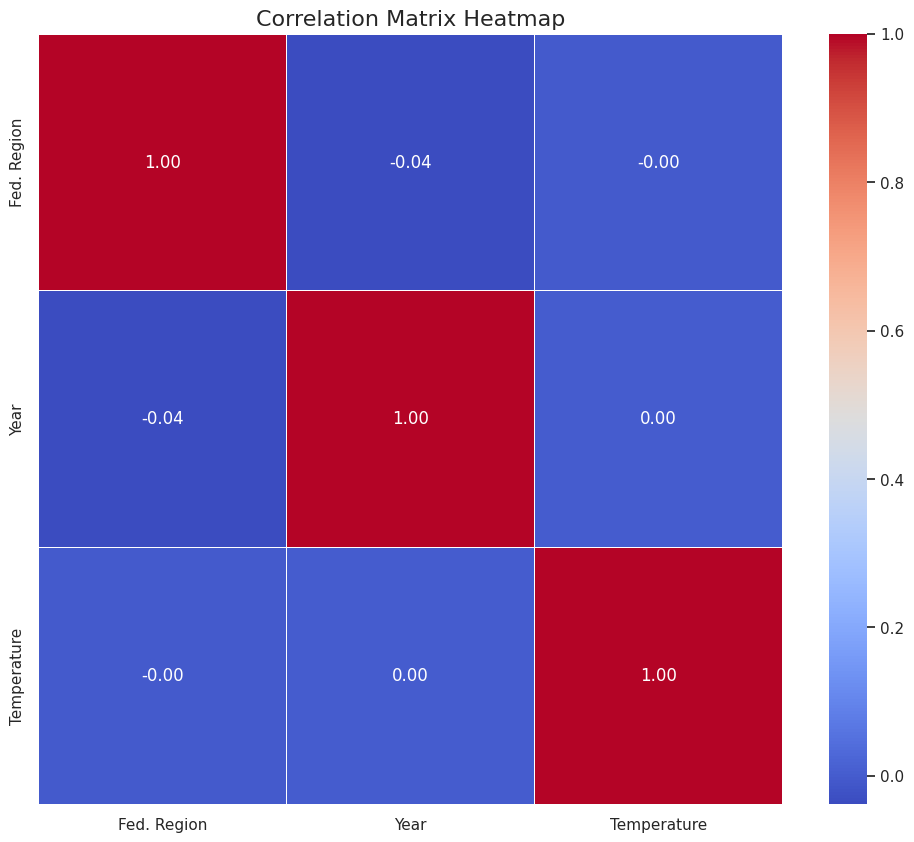

In [5]:
# Data Visualization
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

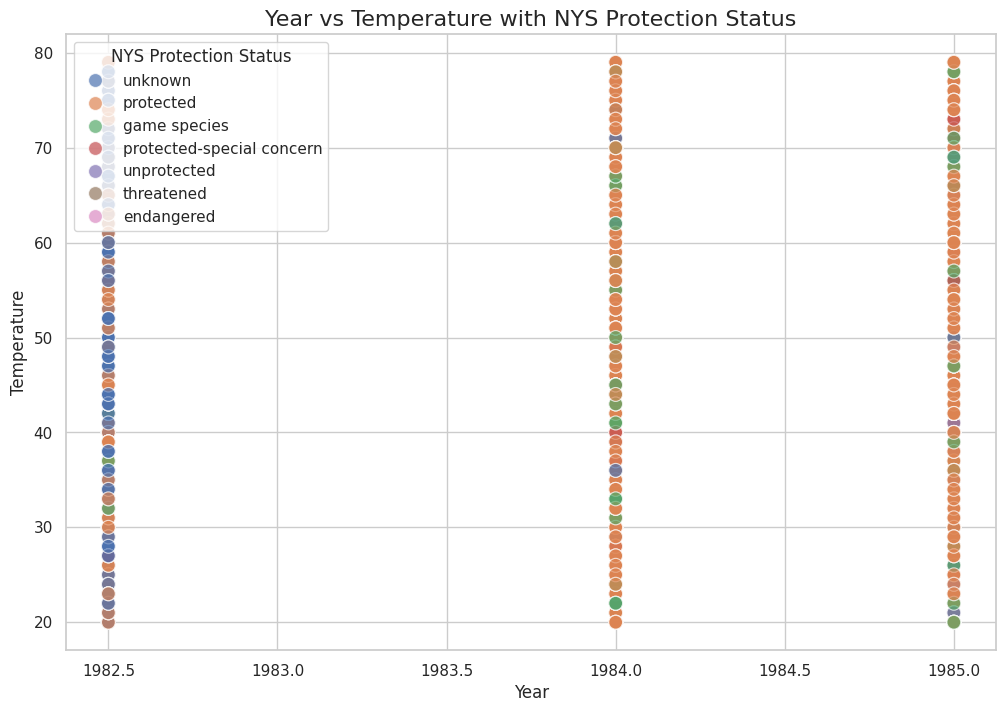

In [6]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Year', y='Temperature', hue='NYS Protection Status', palette="deep", s=100, edgecolor="w", alpha=0.7)
plt.title("Year vs Temperature with NYS Protection Status", fontsize=16)
plt.show()

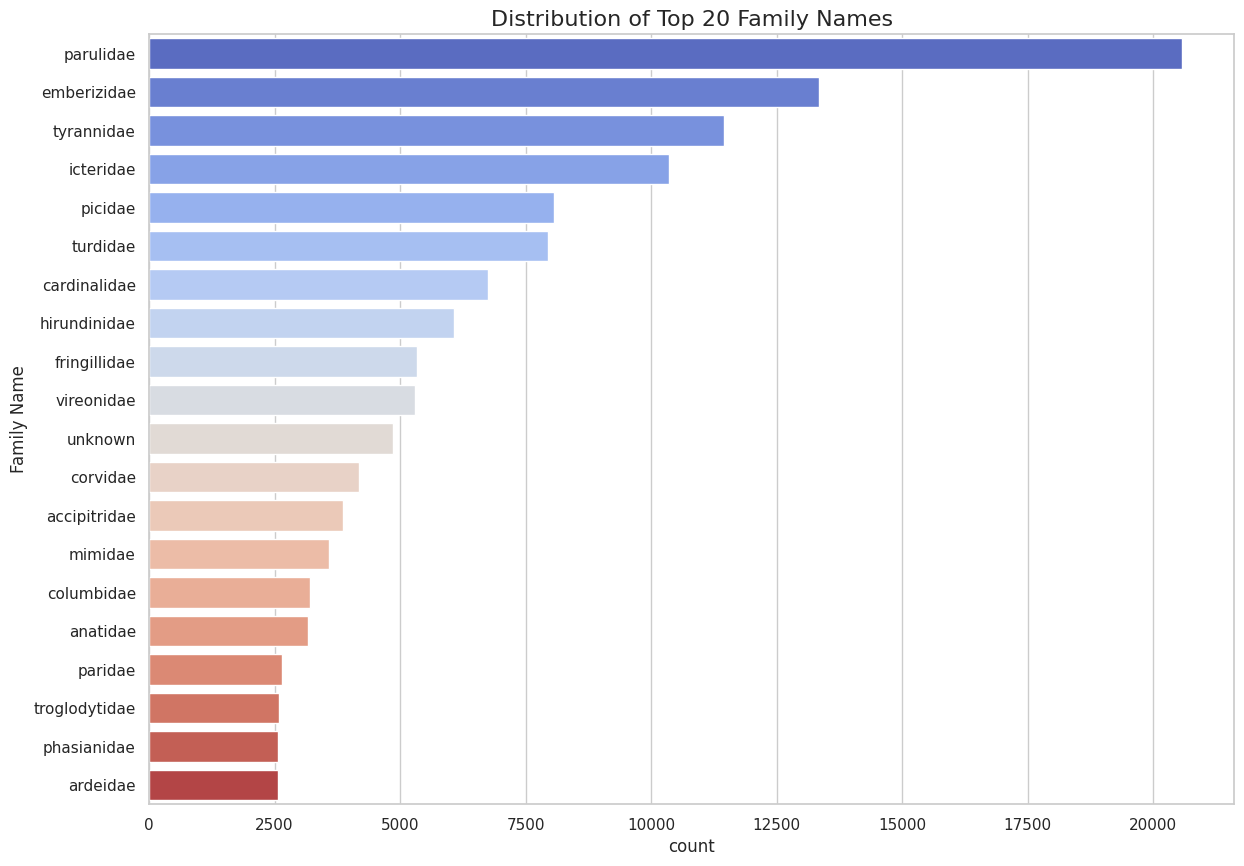

In [7]:
plt.figure(figsize=(14, 10))
sns.countplot(data=df, y='Family Name', order=df['Family Name'].value_counts().index[:20], palette="coolwarm")
plt.title("Distribution of Top 20 Family Names", fontsize=16)
plt.show()

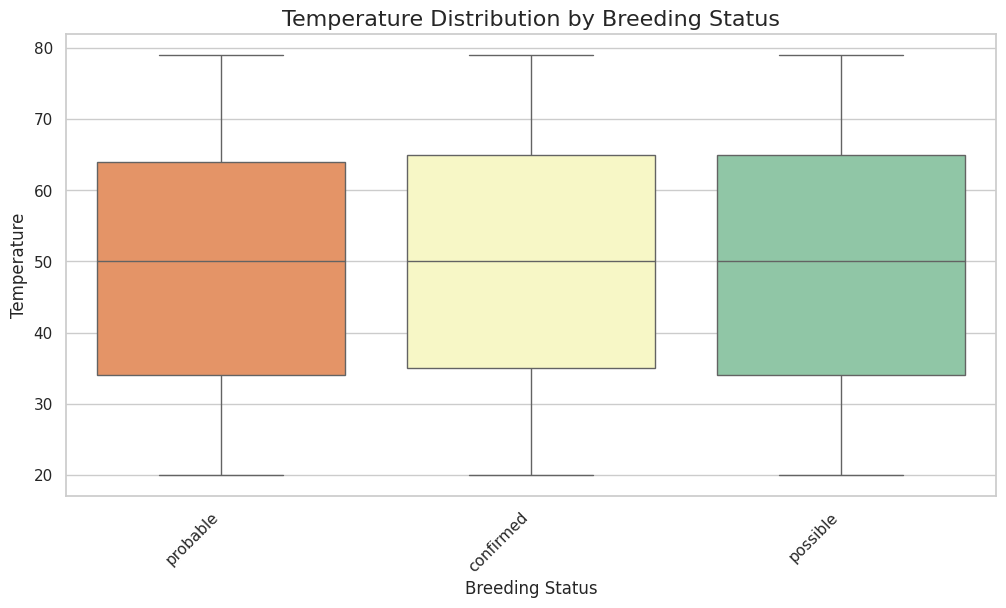

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Breeding Status', y='Temperature', palette="Spectral")
plt.title("Temperature Distribution by Breeding Status", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

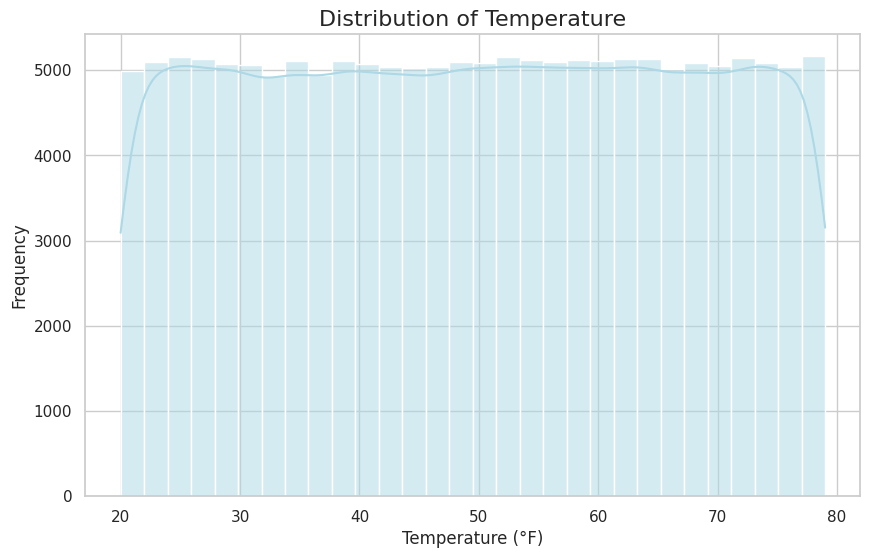

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], bins=30, kde=True, color='lightblue')
plt.title('Distribution of Temperature', fontsize=16)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

In [10]:
#identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

# Task8 - Converting the features with string datatype to categorical
def label_encode(series):
    return pd.Categorical(series).codes

for col in categorical_columns:
    df[col] = label_encode(df[col])

# Creating binary target for 'Breeding Status'
df['Breeding Status Binary'] = (df['Breeding Status'] == df['Breeding Status'].max()).astype(int)

# Task7 - Identify uncorrelated or unrelated features
# Computing the correlation matrix
correlation_matrix = df.corr()

# Getting the correlation with the target
target_corr = correlation_matrix['Breeding Status Binary'].abs().sort_values(ascending=False)

# Setting a threshold for low correlation to 0.3
threshold = 0.03

# Identifying the features with low correlation
low_corr_features = target_corr[target_corr < threshold].index.tolist()
sufficient_corr_features = target_corr[target_corr >= threshold].index.tolist()

print("\nFeatures with low correlation to 'Breeding Status' that could be dropped:")
print(low_corr_features)
print("\nFeatures sufficiently correlated with 'Breeding Status' that should not be dropped:")
print(sufficient_corr_features)


Features with low correlation to 'Breeding Status' that could be dropped:
['Fed. Region', 'Scientific Name', 'Block ID', 'Temperature', 'Year']

Features sufficiently correlated with 'Breeding Status' that should not be dropped:
['Breeding Status Binary', 'Breeding Status', 'Breeding Behavior', 'Family Description', 'Family Name', 'NYS Protection Status', 'Common Name', 'County']


In [11]:
# Task9 - Normalizing non-categorical features
def normalize(column):
    min_val = column.min()
    max_val = column.max()
    if min_val == max_val:
        return pd.Series(0, index=column.index)
    return (column - min_val) / (max_val - min_val)

for col in numeric_columns:
    df[col] = normalize(df[col])

print("\nShape of the dataset:", df.shape)
print("\nFirst few rows of the processed dataset:")
print(df.head())
print("\nColumn datatypes:")
print(df.dtypes)


Shape of the dataset: (152408, 13)

First few rows of the processed dataset:
   Fed. Region  Block ID  County  Common Name  Scientific Name  \
0     0.357143      3345      56          204              216   
1     0.571429      3034       0            1               94   
2     0.571429      3345       0            3               18   
3     0.571429      3475       0            3               18   
4     0.571429      3039       0            5               69   

   NYS Protection Status  Family Name  Family Description  Breeding Behavior  \
0                      5           47                  41                112   
1                      2           45                  41                107   
2                      1            3                  35                110   
3                      1            3                  35                114   
4                      1           13                  14                112   

   Year  Temperature  Breeding Status  Breed

In [12]:
# Saving the processed dataset
df.to_csv('processed_breeding_bird_atlas_numeric.csv', index=False)
print("Processed dataset saved as 'processed_breeding_bird_atlas_numeric.csv'")

Processed dataset saved as 'processed_breeding_bird_atlas_numeric.csv'


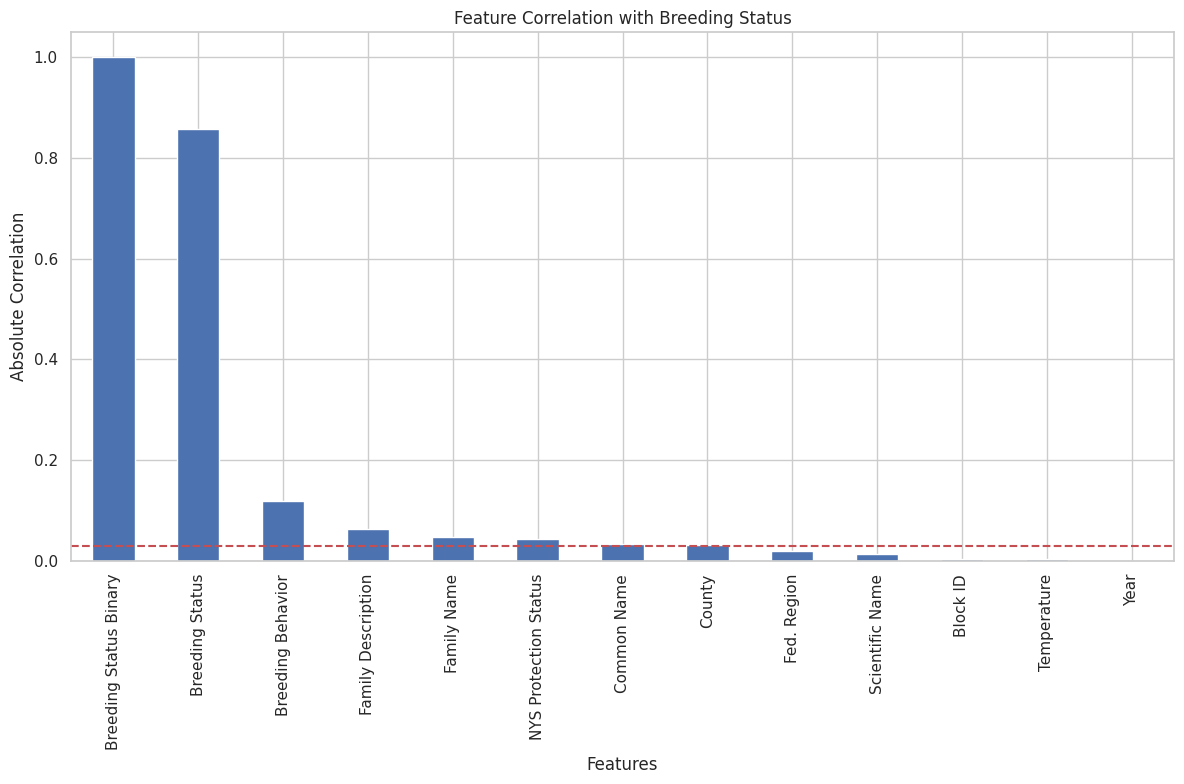

In [13]:
# Visualizing the correlation with target with the
plt.figure(figsize=(12, 8))
target_corr.plot(kind='bar')
plt.title('Feature Correlation with Breeding Status')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()